In [1]:
import pandas as pd

# Load the Excel file
file_path = 'GeneralAviationDashboard_Data_20221208_Public.xlsx'
sheet_name = 'Accidents'

# Read the data from the "Accidents" sheet
try:
    accidents_df = pd.read_excel(file_path, sheet_name=sheet_name)
    read_success = True
except Exception as e:
    read_success = False
    error_message = str(e)

read_success, accidents_df.head() if read_success else print(error_message)

# Filter the dataset for accidents in Alaska with a fatal injury level
# filtered_df = accidents_df[(accidents_df['StateOrRegion'] == 'Alaska') & (accidents_df['InjuryLevel'] == 'Fatal')]
filtered_df = accidents_df[(accidents_df['StateOrRegion'] == 'Alaska') & ((accidents_df['FatalInjuries'] > 0) | (accidents_df['SeriousInjuries'] > 0))] #* Filter by fatal or serious injuries only

# filtered_df = accidents_df[(accidents_df['StateOrRegion'] == 'Alaska')]

print(filtered_df.head())  # Displaying the first few rows of the filtered data

       MKey  NTSBNumber                                             Report  \
232   83257  ANC12FA028  https://data.ntsb.gov/carol-repgen/api/Aviatio...   
696   84216  ANC12FA066  https://data.ntsb.gov/carol-repgen/api/Aviatio...   
719   84268  ANC12FA073  https://data.ntsb.gov/carol-repgen/api/Aviatio...   
1015  84872  ANC12FA095  https://data.ntsb.gov/carol-repgen/api/Aviatio...   
1225  85273  ANC13FA001  https://data.ntsb.gov/carol-repgen/api/Aviatio...   

      EventDate       City StateOrRegion        Country   Latitude  \
232  2012-03-30  Sleetmute        Alaska  United States  61.940929   
696  2012-07-18  Fairbanks        Alaska  United States  65.453887   
719  2012-07-10      Homer        Alaska  United States  59.639999   
1015 2012-08-31      Homer        Alaska  United States  59.526111   
1225 2012-10-07  Aleknagik        Alaska  United States  59.972221   

       Longitude  FatalInjuries  SeriousInjuries InjuryLevel  
232  -157.620376            2.0              Na

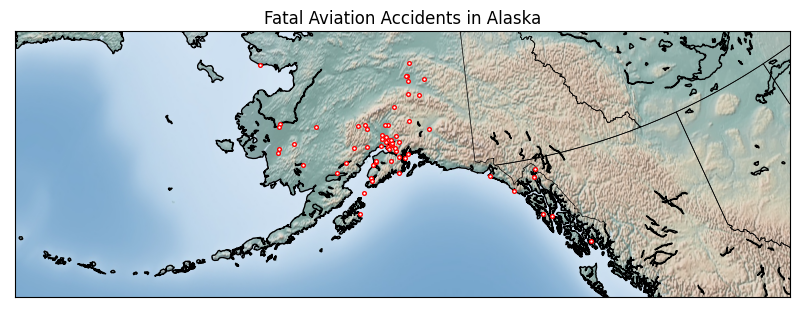

In [2]:

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Define the boundaries for the map of Alaska
lat_min, lat_max = filtered_df.Latitude.min() - 1, filtered_df.Latitude.max() + 1
lon_min, lon_max = filtered_df.Longitude.min() - 1, filtered_df.Longitude.max() + 1

# Create a Basemap instance for Alaska
plt.figure(figsize=(10, 10))
map = Basemap(projection='lcc', resolution='i',
              lat_0=(lat_max + lat_min) / 2, lon_0=(lon_max + lon_min) / 2,
              width=1.1*(lon_max - lon_min)*111e3, height=1.1*(lat_max - lat_min)*111e3)

# Draw coastlines, countries, and states
map.drawcoastlines()
map.drawcountries()
map.drawstates()

# Draw topographic image
# map.etopo()
map.shadedrelief()

# Plot the accident locations
x, y = map(filtered_df.Longitude.values, filtered_df.Latitude.values)
map.scatter(x, y, marker='o', color='w', zorder=5, edgecolor='r', s=7)

plt.title('Fatal Aviation Accidents in Alaska')
plt.show()

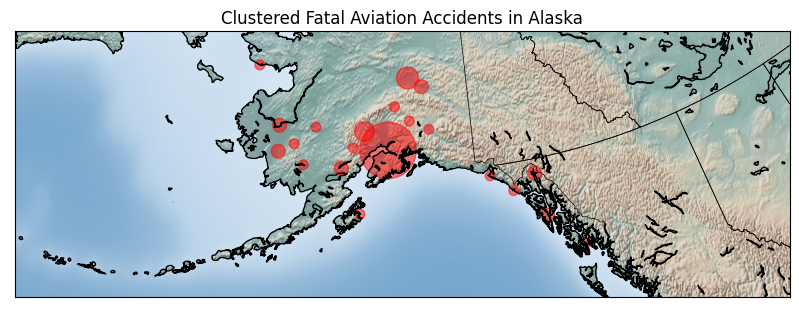

In [3]:
from sklearn.cluster import DBSCAN
import numpy as np

# Prepare the data for clustering (latitude and longitude)
coords = filtered_df[['Latitude', 'Longitude']].values

# Use DBSCAN to cluster the data
# The eps parameter is the maximum distance between two samples for them to be considered as in the same neighborhood
# The min_samples parameter is the number of samples in a neighborhood for a point to be considered as a core point
db = DBSCAN(eps=1, min_samples=1).fit(coords)
labels = db.labels_

# Number of clusters, ignoring noise if present
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Create an empty list to store cluster data
cluster_data = []

for i in range(n_clusters):
    mask = (labels == i)
    cluster_center = [coords[mask][:, 0].mean(), coords[mask][:, 1].mean()]
    cluster_count = mask.sum()
    cluster_data.append({'Latitude': cluster_center[0], 'Longitude': cluster_center[1], 'Count': cluster_count})

# Convert the list of dictionaries to a DataFrame
clusters = pd.DataFrame(cluster_data)

# Re-plotting the clusters
plt.figure(figsize=(10, 10))
map = Basemap(projection='lcc', resolution='i',
              lat_0=(lat_max + lat_min) / 2, lon_0=(lon_max + lon_min) / 2,
              width=1.1*(lon_max - lon_min)*111e3, height=1.1*(lat_max - lat_min)*111e3)

map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.shadedrelief()
# map.etopo()
# map.bluemarble()

# Plot the clusters as bubbles
x, y = map(clusters.Longitude.values, clusters.Latitude.values)
bubble_sizes = 50 * clusters.Count  # Adjust the bubble size multiplier as needed
map.scatter(x, y, marker='o', color='r', s=bubble_sizes, alpha=0.5)

plt.title(f'Clustered Fatal Aviation Accidents in Alaska')
plt.show()


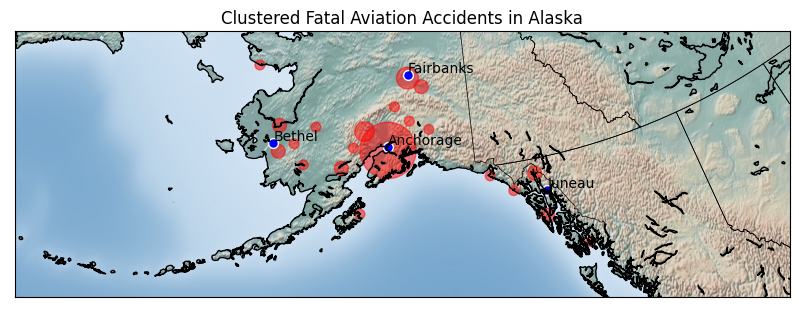

In [4]:
# List of major cities in Alaska with their coordinates
alaska_cities = {
    'Anchorage': (61.2181, -149.9003),
    'Fairbanks': (64.8378, -147.7164),
    'Juneau': (58.3019, -134.4197),
    # 'Sitka': (57.0531, -135.3300),
    # 'Ketchikan': (55.3422, -131.6461),
    # 'Wasilla': (61.5814, -149.4394),
    # 'Kenai': (60.5544, -151.2583),
    # 'Kodiak': (57.7900, -152.4072),
    'Bethel': (60.7922, -161.7558),
    # 'Palmer': (61.5997, -149.1128)
}

# Re-plotting the map with the cities
plt.figure(figsize=(10, 10))
map = Basemap(projection='lcc', resolution='i',
              lat_0=(lat_max + lat_min) / 2, lon_0=(lon_max + lon_min) / 2,
              width=1.1*(lon_max - lon_min)*111e3, height=1.1*(lat_max - lat_min)*111e3)

map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.shadedrelief()

# Plot the clusters as bubbles
x, y = map(clusters.Longitude.values, clusters.Latitude.values)
bubble_sizes = 50 * clusters.Count
map.scatter(x, y, marker='o', color='r', s=bubble_sizes, alpha=0.5)

# Add cities to the map
for city, (lat, lon) in alaska_cities.items():
    x, y = map(lon, lat)
    map.scatter(x, y, marker='o', color='b', edgecolor='white', s=50)
    plt.text(x, y, city, color='black', ha='left', va='bottom', fontsize=10)

plt.title(f'Clustered Fatal Aviation Accidents in Alaska')
plt.show()